In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import seaborn as sns
from tqdm.auto import tqdm
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import warnings
warnings.filterwarnings('ignore')
from sklearn.utils import resample

In [42]:
df = pd.read_csv('combined_with_normal.csv')
df.head()
df.describe()
print(df)

            date  weather_code  temperature_2m_max  temperature_2m_min  \
0     1941-05-20          51.0           29.550000               26.80   
1     1947-10-20           1.0           28.350000               24.60   
2     1958-10-19          51.0           29.550000               24.10   
3     1960-10-08          63.0           27.650000               25.70   
4     1960-10-29          61.0           28.900000               23.25   
...          ...           ...                 ...                 ...   
2068  2011-05-20          63.0           28.950001               25.00   
2069  1948-01-15           1.0           25.299999               18.90   
2070  1984-04-30          61.0           30.500000               25.85   
2071  1995-07-20          63.0           26.799999               24.50   
2072  2001-09-06          61.0           28.049999               25.60   

      temperature_2m_mean  precipitation_sum   rain_sum  wind_speed_10m_max  \
0               28.243750       

In [47]:
df_1 = df[(df['disaster_type'] == 'Flood')]
df_2 = df[(df['disaster_type'] == 'Storm')]
df_3 = df[(df['disaster_type'] == 'Epidemic')]
df_4 = df[(df['disaster_type'] == 'Normal')]

# Find the smallest class size
min_size =min(len(df_1), len(df_2), len(df_3), len(df_4))

# Randomly undersample the majority classes
df_1_downsampled = resample(df_1, replace=False, n_samples=min_size, random_state=42)
df_2_downsampled = resample(df_2, replace=False, n_samples=min_size, random_state=42)
df_3_downsampled = resample(df_3, replace=False, n_samples=min_size, random_state=42)
df_4_downsampled = resample(df_4, replace=False, n_samples=min_size, random_state=42)

df_balanced = pd.concat([df_1_downsampled, df_2_downsampled, df_3_downsampled, df_4_downsampled])
print(df_balanced)

            date  weather_code  temperature_2m_max  temperature_2m_min  \
231   1993-07-17          61.0           28.650000           25.500000   
1053  2005-07-13          61.0           28.250000           25.500000   
287   1994-06-01          61.0           31.150000           26.950000   
91    1990-07-28          61.0           26.050000           25.000000   
1131  2006-07-04          55.0           28.800000           25.900000   
...          ...           ...                 ...                 ...   
1964  1951-11-13           2.0           27.750000           21.900000   
1872  2012-06-11           1.0           30.950001           26.950001   
1950  1967-10-12          51.0           28.700001           23.049999   
2037  1957-11-05           1.0           28.450001           20.950001   
1960  1973-12-08          63.0           23.600000           19.850000   

      temperature_2m_mean  precipitation_sum   rain_sum  wind_speed_10m_max  \
231             26.743752       

In [48]:
Xm = df_balanced.loc[:, df_balanced.columns != 'disaster_type' ]
Y = df_balanced.loc[:, df_balanced.columns == 'disaster_type']

X = Xm.drop(columns='date')
print(X)

      weather_code  temperature_2m_max  temperature_2m_min  \
231           61.0           28.650000           25.500000   
1053          61.0           28.250000           25.500000   
287           61.0           31.150000           26.950000   
91            61.0           26.050000           25.000000   
1131          55.0           28.800000           25.900000   
...            ...                 ...                 ...   
1964           2.0           27.750000           21.900000   
1872           1.0           30.950001           26.950001   
1950          51.0           28.700001           23.049999   
2037           1.0           28.450001           20.950001   
1960          63.0           23.600000           19.850000   

      temperature_2m_mean  precipitation_sum   rain_sum  wind_speed_10m_max  \
231             26.743752          20.800001  20.800001           24.023088   
1053            26.531250          19.700000  19.700000           29.091030   
287             28

In [49]:
print(Y['disaster_type'].value_counts())

disaster_type
Flood       215
Storm       215
Epidemic    215
Normal      215
Name: count, dtype: int64


In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

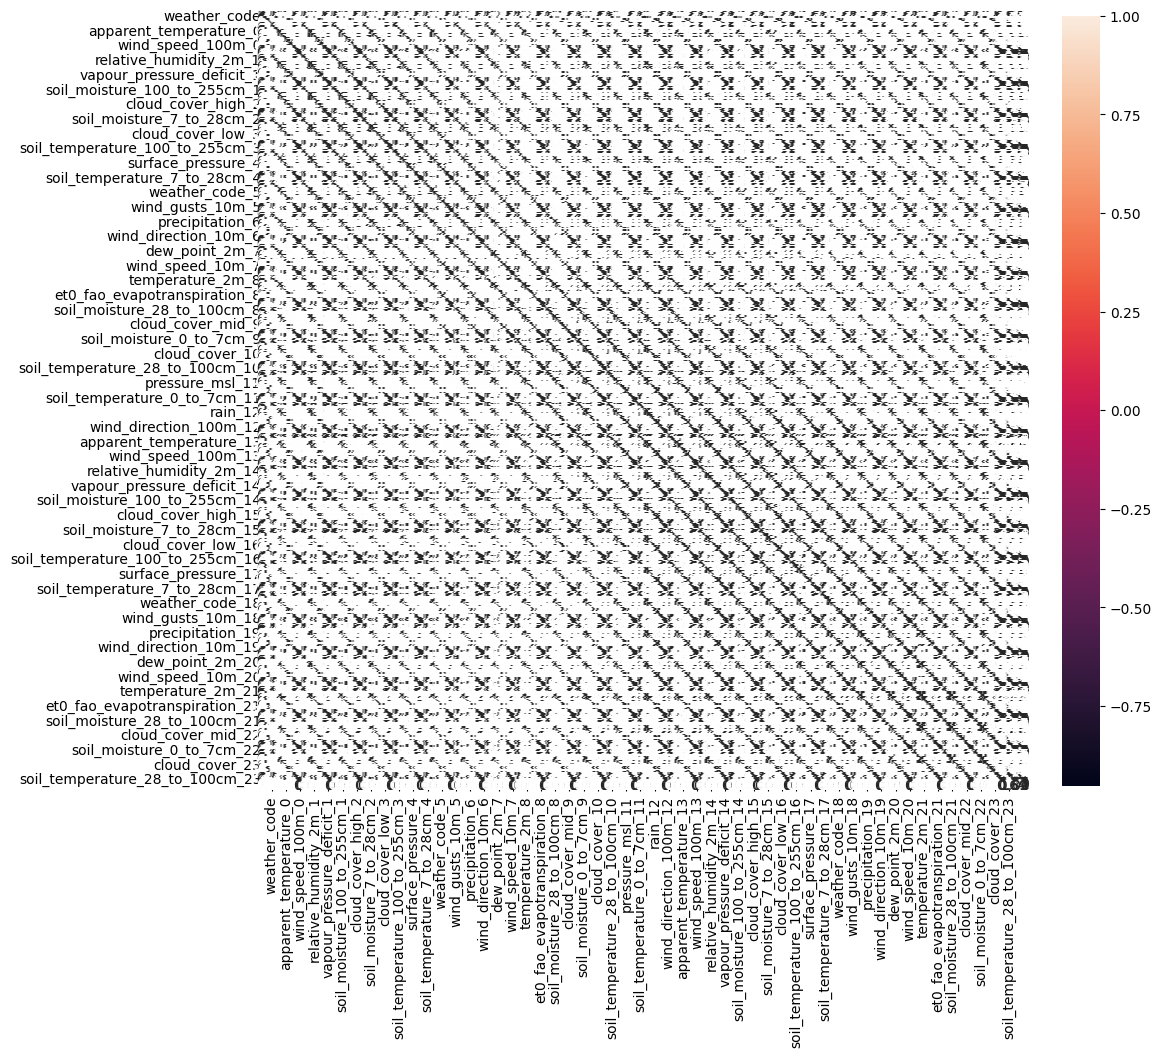

Reduced training set shape: (688, 191)
Reduced testing set shape: (172, 191)


In [51]:
corr_matrix = X_train.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.show()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop the features
X_train_reduced = X_train.drop(columns=to_drop)
X_test_reduced = X_test.drop(columns=to_drop)

print(f"Reduced training set shape: {X_train_reduced.shape}")
print(f"Reduced testing set shape: {X_test_reduced.shape}")

In [52]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_reduced, y_train)

RandomForestClassifier(random_state=42)

In [53]:
importances = clf.feature_importances_
feature_importances = pd.DataFrame({'feature': X_train_reduced.columns, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

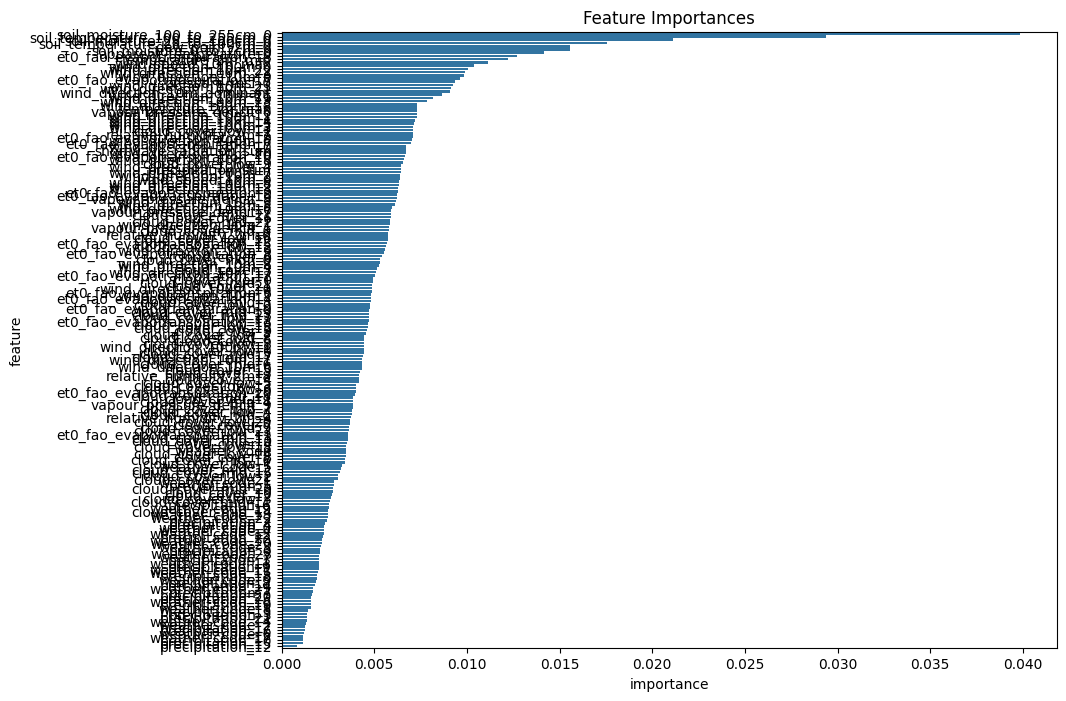

In [54]:
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('Feature Importances')
plt.show()

In [55]:
threshold = 0.01
selected_features = feature_importances[feature_importances['importance'] > threshold]['feature']

X_train_selected = X_train_reduced[selected_features]
X_test_selected = X_test_reduced[selected_features]
print(X_train_selected.shape)
print(X_test_selected.shape)

(688, 12)
(172, 12)


In [56]:
clf_selected = RandomForestClassifier(n_estimators=100, random_state=42)
clf_selected.fit(X_train_selected, y_train)

RandomForestClassifier(random_state=42)

In [57]:
y_pred = clf_selected.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy:.2f}")

Accuracy on test set: 0.71


In [59]:
import time
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

In [60]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

In [63]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [64]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_scaled, y_train_encoded)

# Predict and evaluate
rf_y_pred = rf_clf.predict(X_test_scaled)
rf_accuracy = accuracy_score(y_test_encoded, rf_y_pred)
print(f"RandomForest Accuracy: {rf_accuracy:.2f}")

RandomForest Accuracy: 0.69


In [65]:
catboost_clf = CatBoostClassifier(iterations=100, random_seed=42, verbose=0)
catboost_clf.fit(X_train_scaled, y_train_encoded)

# Predict and evaluate
catboost_y_pred = catboost_clf.predict(X_test_scaled)
catboost_accuracy = accuracy_score(y_test_encoded, catboost_y_pred)
print(f"CatBoost Accuracy: {catboost_accuracy:.2f}")

CatBoost Accuracy: 0.67


In [66]:
xgboost_clf = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgboost_clf.fit(X_train_scaled, y_train_encoded)

# Predict and evaluate
xgboost_y_pred = xgboost_clf.predict(X_test_scaled)
xgboost_accuracy = accuracy_score(y_test_encoded, xgboost_y_pred)
print(f"XGBoost Accuracy: {xgboost_accuracy:.2f}")

XGBoost Accuracy: 0.74


In [67]:
lgbm_clf = LGBMClassifier(n_estimators=100, random_state=42)
lgbm_clf.fit(X_train_scaled, y_train_encoded)

# Predict and evaluate
lgbm_y_pred = lgbm_clf.predict(X_test_scaled)
lgbm_accuracy = accuracy_score(y_test_encoded, lgbm_y_pred)
print(f"LightGBM Accuracy: {lgbm_accuracy:.2f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001160 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2099
[LightGBM] [Info] Number of data points in the train set: 688, number of used features: 12
[LightGBM] [Info] Start training from score -1.380497
[LightGBM] [Info] Start training from score -1.369003
[LightGBM] [Info] Start training from score -1.403890
[LightGBM] [Info] Start training from score -1.392125
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [68]:
accuracies = {
    "RandomForest": rf_accuracy,
    "CatBoost": catboost_accuracy,
    "XGBoost": xgboost_accuracy,
    "LightGBM": lgbm_accuracy
}

for model, accuracy in accuracies.items():
    print(f"{model} Accuracy: {accuracy:.2f}")

RandomForest Accuracy: 0.69
CatBoost Accuracy: 0.67
XGBoost Accuracy: 0.74
LightGBM Accuracy: 0.74


As XGBoost and LightGBM had the highest accuracies around 74%, we'll be using those.

In [69]:
import pickle
pickle.dump(xgboost_clf, open("Disaster_pred_XGBoost", "wb"))

In [70]:
pickle.dump(lgbm_clf, open("Disaster_pred_LightGBM", "wb"))

In [71]:
pickle.dump(clf_selected, open("Disaster_pred_RandomForest", "wb"))